In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import seaborn as sns
from keras import models
from keras import layers
from keras import regularizers
import os
from scipy.stats import gaussian_kde
from numpy.random import seed
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv('../data/train-halos_and_gals.csv')
df_test = pd.read_csv('../data/test-halos_and_gals.csv')

In [3]:
x_train = np.array([df_train['M_h'], df_train['R_h'], df_train['V_h']]).T
x_test = np.array([df_test['M_h'], df_test['R_h'], df_test['V_h']]).T

y_train = np.array([df_train['M_g'], df_train['color_g'], df_train['SFR_g']]).T
y_test = np.array([df_test['M_g'], df_test['color_g'], df_test['SFR_g']]).T

In [4]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1211, 3), (303, 3), (1211, 3), (303, 3))

In [5]:
#Preparing data
mean_data = np.mean(x_train, axis = 0)
std_data = np.std(x_train, axis = 0)
mean_data, std_data

(array([10.72031404, -6.69246455,  2.14441201]),
 array([0.57831041, 0.19277028, 0.24073891]))

In [6]:
x_train -= mean_data
x_train /= std_data
x_test -= mean_data
x_test /= std_data

In [7]:
def base_model():
    model = models.Sequential() 
    model.add(layers.Dense(64, activation = 'relu', input_shape = (x_train.shape[1],)))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(3))
    
    print(model.summary())
    
    model.compile(optimizer = 'Adamax', loss = 'mse')
    
    return model

In [8]:
my_model = base_model()
my_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
#Fitting data
no_epochs = 100
batch_size = 100
validation_split = 0.2
history = my_model.fit(x_train, y_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)
history

Epoch 1/100
10/10 [==============================] - 1s 23ms/step - loss: 38.5779 - val_loss: 37.0760
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 35.9973 - val_loss: 34.6685
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 33.6774 - val_loss: 32.3003
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 31.3672 - val_loss: 29.8720
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 28.8915 - val_loss: 27.3057
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 26.2803 - val_loss: 24.5401
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 23.4604 - val_loss: 21.5828
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 20.4847 - val_loss: 18.5231
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 17.4438 - val_loss: 15.4857
Epoch 10/100
10/10 [==============================] - 0s 5ms/step - loss: 14.5016 - val_lo

In [10]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Text(0.5, 0, 'Epochs')

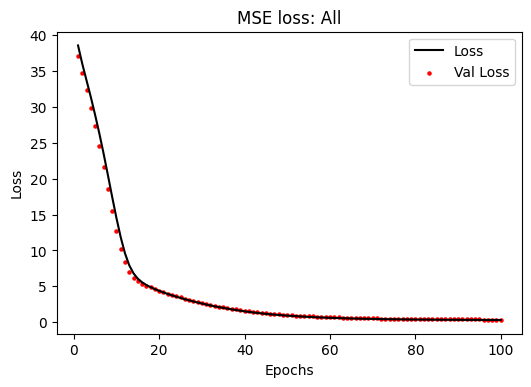

In [11]:
plt.figure(dpi=100)
plt.plot(epochs, train_loss, color = 'black',label = 'Loss')
plt.scatter(epochs, train_val_loss, s = 5, color = 'red', label = 'Val Loss')
plt.legend()  
plt.title('MSE loss: All')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [12]:
#Prediction
prediction = my_model.predict(x_test)

10/10 [==============================] - 0s 1ms/step


In [13]:
#Scores
MSE = np.zeros((3))
for i in range(3):
    MSE[i] = mean_squared_error(prediction[:, i], y_test[:, i])
MSE

array([0.10321301, 0.02665155, 0.69692494])

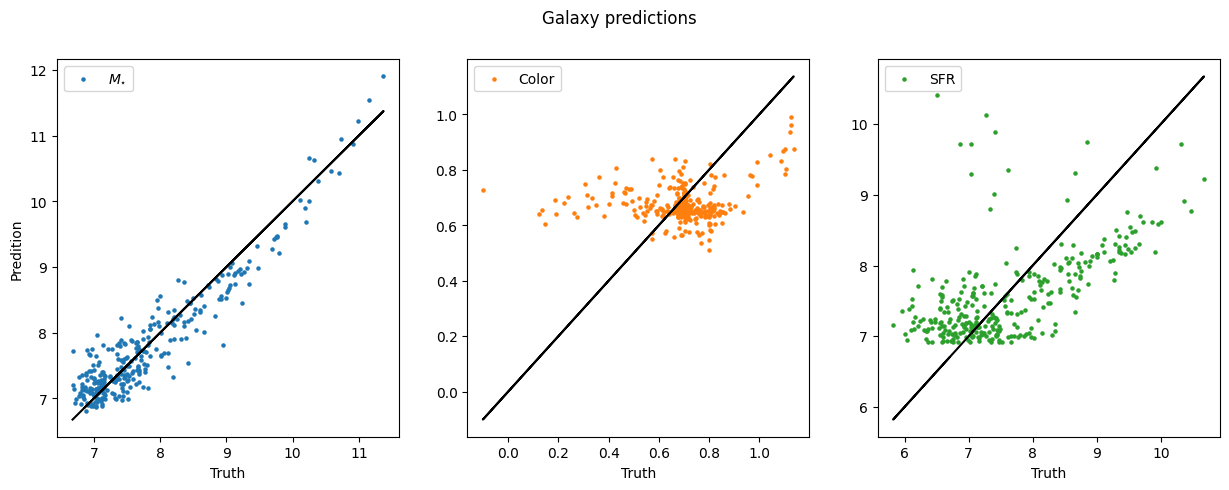

In [14]:
fig = plt.figure(dpi = 100, figsize = (15, 5))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots()

fig.suptitle('Galaxy predictions')

axs[0].scatter(y_test[:, 0], prediction[:, 0], s = 5, color = 'C0', label = '$M_{\star}$')
axs[0].set_xlabel(r'Truth')
axs[0].plot(y_test[:, 0], y_test[:, 0], color = 'black')
axs[0].set_ylabel(r'Predition')
axs[0].legend()

axs[1].scatter(y_test[:, 1], prediction[:, 1], s = 5, color = 'C1', label = 'Color')
axs[1].set_xlabel(r'Truth')
axs[1].plot(y_test[:, 1], y_test[:, 1], color = 'black')
axs[1].legend()

axs[2].scatter(y_test[:, 2], prediction[:, 2], s = 5, color = 'C2', label = 'SFR')
axs[2].plot(y_test[:, 2], y_test[:, 2], color = 'black')
axs[2].set_xlabel(r'Truth')
axs[2].legend()

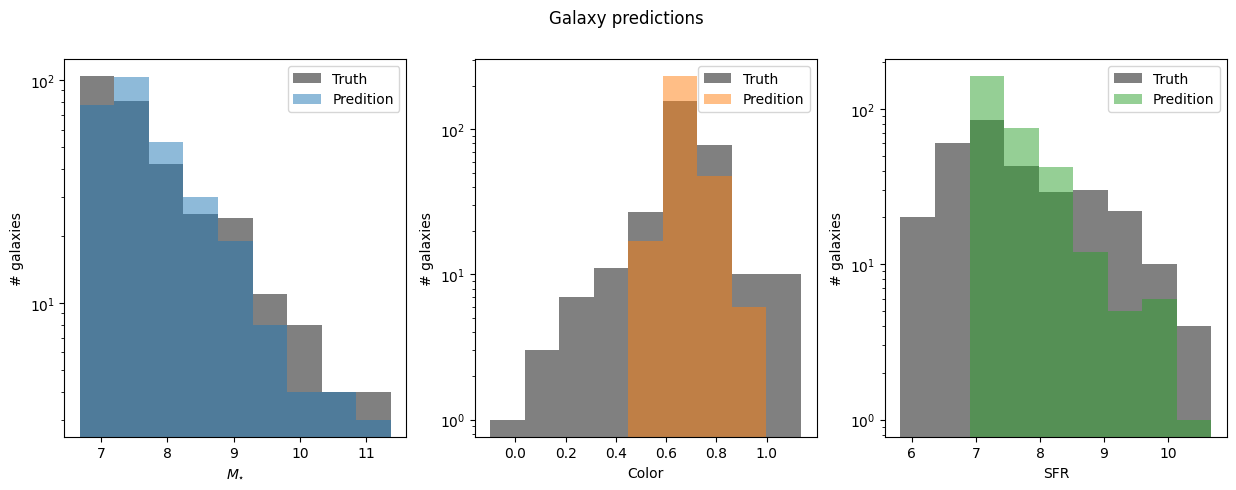

In [15]:
fig = plt.figure(dpi = 100, figsize = (15, 5))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots()

fig.suptitle('Galaxy predictions')

bins = np.linspace(np.min(y_test[:, 0]), np.max(y_test[:, 0]), 10)
axs[0].hist(y_test[:, 0], bins = bins, color = 'gray', label = 'Truth')
axs[0].hist(prediction[:, 0], bins = bins, color = 'C0', alpha = 0.5, label = 'Predition')
axs[0].set_xlabel(r'$M_{\star}$')
axs[0].set_ylabel(r'# galaxies')
axs[0].legend()
axs[0].set_yscale('log')

bins = np.linspace(np.min(y_test[:, 1]), np.max(y_test[:, 1]), 10)
axs[1].hist(y_test[:, 1], bins = bins, color = 'gray', label = 'Truth')
axs[1].hist(prediction[:, 1], bins = bins, color = 'C1', alpha = 0.5, label = 'Predition')
axs[1].set_xlabel(r'Color')
axs[1].set_ylabel(r'# galaxies')
axs[1].legend()
axs[1].set_yscale('log')

bins = np.linspace(np.min(y_test[:, 2]), np.max(y_test[:, 2]), 10)
axs[2].hist(y_test[:, 2], bins = bins, color = 'gray', label = 'Truth')
axs[2].hist(prediction[:, 2], bins = bins, color = 'C2', alpha = 0.5, label = 'Predition')
axs[2].set_xlabel(r'SFR')
axs[2].set_ylabel(r'# galaxies')
axs[2].legend()
axs[2].set_yscale('log')